In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import pickle

from bresenham import bresenham

In [2]:
data_path = '../output/coord_dict_large.p'
mask_path = '../output/europe_mask.npy'

compass = {
    0: np.array([0, 1]), #E
    1: np.array([1, 0]), #N
    2: np.array([0, -1]), #W
    3: np.array([-1, 0]) #S
}

stationary_base = 0
translate_base = 1
rotate_base = 5

WAIT_REWARD = 0
ACTIVE_COLLECTING_REWARD = 1
PASSIVE_COLLECTING_REWARD = 1
TRANSLATE_REWARD = 0
ROTATE_REWARD = 0
HIT_WALL_REWARD = -10


INIT_SEED = 123
MAP_W = 350
MAP_H = 170

In [3]:
def triangle_area(A, B, C):
    a = np.linalg.norm(B-C)
    b = np.linalg.norm(A-C)
    c = np.linalg.norm(A-B)
    
    # Calculate Semi-perimeter
    s = (a + b + c) / 2

    # calculate the area
    area = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    
    return area

def is_in_triangle(P, A, B, C, eps=1e-6):
    area_ABC = triangle_area(A, B, C)
    
    area_ABP = triangle_area(A, B, P)
    area_ACP = triangle_area(A, C, P)
    area_BCP = triangle_area(B, C, P)
    
    return abs(area_ABC - (area_ABP + area_ACP + area_BCP)) < eps
    
def is_in_rectangle(P, A, B, C, D, eps=1e-6):
    return is_in_triangle(P, A, B, C, eps) or is_in_triangle(P, A, C, D, eps)


In [4]:
def crossing(A, B, C, D, eps=1e-6):
    if (max(A[0], B[0]) < min(C[0], D[0])):
        return False # There is no mutual abcisses
    
    if (max(A[1], B[1]) < min(C[1], D[1])):
        return False # There is no mutual ordonnees
    
    Ia = [max(min(A[0], B[0]), min(C[0],D[0])),
          min(max(A[0], B[0]), max(C[0], D[0]))]
    
    A1 = (A[1]-B[1])/(A[0]-B[0] + eps) # Pay attention to not dividing by zero
    A2 = (C[1]-D[1])/(C[0]-D[0] + eps) # Pay attention to not dividing by zero
    b1 = A[1]-A1*A[0]
    b2 = C[1]-A2*C[0]
    
    if (A1 == A2):
        return False # Parallel segments
    
    Xa = (b2 - b1) / (A1 - A2) # Once again, pay attention to not dividing by zero
    
    
    if Xa + eps < max(min(A[0], B[0]), min(C[0], D[0])) or Xa -eps > min(max(A[0], B[0]), max(C[0], D[0])):
        return False # intersection is out of bound
    else:
        return True

In [5]:
# crossing(np.array([0,0]), np.array([5,0]), np.array([5 + 1e-6, 1]), np.array([5+1e-6, -1]))

In [6]:
class FishingNet:
    
    def __init__(self, length, seed=0):
        if seed:
            self.pos_center = np.array([np.random.randint(MAP_W, random_seed=seed), np.random.randint(MAP_H, random_seed=seed)])
        else:
            self.pos_center = np.array([np.random.randint(MAP_W), np.random.randint(MAP_H)])
            
        self.length = length
        self.num_rots = 4
        self.angle = np.random.randint(self.num_rots)
        self.rotations = range(self.num_rots)
        angle_step = np.pi/self.num_rots
        self.angles_list = [(np.cos(angle_step * i), np.sin(angle_step * i)) for i in range(num_rots)]
        
    def translate(self, direction, wall_matrix):
        reward = 0
        old_pos = self.pos_center
        self.pos_center = self.pos_center + compass[direction]
        list_bresenham = self.compute_bresenham()
        if any(wall_matrix[list_bresenham]):
            reward += HIT_WALL_REWARD
            self.pos_center = old_pos
        else:
            reward += TRANSLATE_REWARD
            
        return reward
    
    def rotate(self, rotation, wall_matrix):
    # TODO: Penalize out of bounds or walled extrimities 
        reward = 0
        old_rot = self.rotation
        
        self.rotation = self.rotation + rotation
        if new_rot == self.num_rots:
            new_rot = 0
        elif new_rot == -1:
            new_rot = self.num_rots -1
        
        list_bresenham = self.compute_bresenham()
        if any(wall_matrix[list_bresenham]):
            reward += HIT_WALL_REWARD
            self.rotation = old_rot
        else:
            reward += ROTATE_REWARD 
            
        return reward
    
    def end_points(self):
        return (self.pos_center + self.length/2 * self.angles_list[self.angle], self.pos_center - self.length/2 * self.angles_list[self.angle])
    
    def calculate_bresenham(self):
        end_points = self.end_points()
        return list(bresenham(endpoints[0][0], endpoints[0][1], endpoints[1][0], endpoints[1][1]))

In [7]:
class Environment:
    
    def __init__(self, data_path, mask, fishnet_length, n_fishing_nets=1):
        self.mask = mask.T
        self.n_fishing_nets = n_fishing_nets
        self.fishnet_length = fishnet_length
        self.data_path = data_path
    
    def reset(self):
        self.t = 0
        with open(self.data_path, 'rb') as f:
            self.data = pickle.load(f)
        self.particles = self.data[self.t] 
        self.flows = self.data[self.t]
        self.fishing_nets = [FishingNet(self.fishnet_length, self.mask, seed=i+INIT_SEED) for i in range(self.n_fishing_nets)]
        self.fishnet_pos_history = []
        
    
    def step(self, actions):
        total_reward = 0
        rewards = np.zeros(self.n_fishing_nets)
        for i, fnet in enumerate(self.fishing_nets):
            rewards[i] += self.update_fishing_net(fnet, actions[i])
            
        rewards += self.update_particles()
        self.t += 1
        self.fishnet_pos_history.append(self.fishing_nets[0].end_points())
        return rewards
    
    def remove_particle(self, caught_particles):
        for particle_id in caught_particles:
            for future_step in range(self.t+1, len(self.data)):
                del self.data[future_step][particle_id]
            del self.particles[particle_id]
    
    def update_fishing_net(self, fnet, action):
        """Update fishing nets positions and gather reward on particles caught by the movements"""
        reward = 0
        caught_particles = []
        if action < translate_base: # No movement
            
            return WAIT_REWARD
        elif action < rotate_base: # Translation
            old_end_points = fnet.end_points()
            reward += fnet.translate(action - translate_base, self.mask) # Hit Wall penalty
            new_end_points = fnet.end_points()
            for k, particle in self.particles.items():
                c = fnet.pos_center
                if np.sqrt((c[0]-particle[0])**2 + (c[1]-particle[1])**2) <= fnet.length / 2 +2:
                    if is_in_rectangle(np.array(particle)/10, old_end_points[0], old_end_points[1], new_end_points[0], new_end_points[1]):
                        caught_particles.append(k)
                        reward += ACTIVE_COLLECTING_REWARD
                else: 
                    reward += 0
            self.remove_particle(caught_particles)
            
            return reward + TRANSLATE_REWARD
        else: # Rotation
            old_end_points = fnet.end_points()
            reward += fnet.rotate(2*(action - rotate_base)-1, self.mask) # Hit Wall penalty
            new_end_points = fnet.end_points()
            for k, particle in self.particles.items():
                c = fnet.pos_center
                if np.sqrt((c[0]-particle[0])**2 + (c[1]-particle[1])**2) <= fnet.length / 2 +2:
                    if is_in_triangle(np.array(particle)/10, fnet.pos_center, old_end_points[0], new_end_points[0])\
                    or is_in_triangle(particle, fnet.pos_center, old_end_points[1], new_end_points[1]):    
                        caught_particles.append(k)
                        reward += ACTIVE_COLLECTING_REWARD  
                else:
                    reward += 0
            self.remove_particle(caught_particles)
        
            return reward + ROTATE_REWARD
    
    def update_particles(self):
        """Update particles positions and gather rewards on particles crossing nets"""
        rewards = np.zeros(self.n_fishing_nets)
        new_particles = self.data[self.t+1]

        for i, fnet in enumerate(self.fishing_nets):
            #Update particle position and check if it touches a Net
            
            segment = fnet.end_points()
            #rewards = PASSIVE_COLLECTING_REWARD if is_crossing(diffs[:,0], diffs[:,1], segment[0], segment[1]) # Will be faster if we get it to work
            caught_particles = []
            c = fnet.pos_center
            for k, v in self.particles.items():
                if np.sqrt((c[0]-v[0])**2 + (c[1]-v[1])**2) <= fnet.length / 2 + 2:
                    if is_crossing(np.array(v)/10, np.array(new_particles[k])/10, segment[0], segment[1]):
                        caught_particles.append(k)
                        rewards[i] += PASSIVE_COLLECTING_REWARD 
                else:
                    rewards[i] += 0
            self.remove_particle(caught_particles)

        self.particles = self.data[self.t+1]
        return rewards

    def get_state(self):
        particles_state = np.zeros((MAP_W, MAP_H))
        for k, v in self.data[self.t].items():
            particles_state[int(v[0]/10), int(v[1]/10)] += 1 
        fnet_coords = self.fishing_nets[0].compute_bresenham() # Assume we have only one fishnet
        fnet_state = np.zeros((MAP_W, MAP_H))
        for p in fnet_coords:
            fnet_state[p[0], p[1]] += 1
        return FloatTensor([[particles_state, self.mask, fnet_state, uo, vo]]).cuda()
        
    def close(self):
        raise NotImplementedError

In [8]:
with open(data_path, 'rb') as f:
    data = pickle.load(f)

In [9]:
len(data[0].keys())
mat = np.zeros((MAP_W, MAP_H))
for k, v in data[0].items():
    mat[int(v[0]/10), int(v[1]/10)] += 1

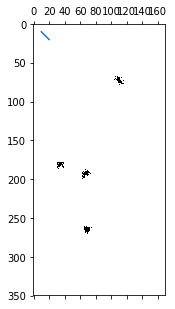

In [15]:
from matplotlib import animation, rc
from IPython.display import HTML
net_test = np.array([[10,10], [20,20]])

fig, ax = plt.subplots(1, 1, figsize=[5, 5])
def init(fig, ax):
    mat = np.zeros((MAP_W, MAP_H))
    for k, v in data[0].items():
        mat[int(v[0]/10), int(v[1]/10)] += 1
    ax.spy(mat)

def simulate(i):
    mat = np.zeros((MAP_W, MAP_H))
    net_test = np.array([[10,10], [20,20]])
    plt.cla()

    if i ==4:
        net_test +=20
        
    l = matplotlib.lines.Line2D([net_test[0][0],net_test[1][0]], [net_test[0][1],net_test[1][1]])
    
    for k, v in data[i].items():
        mat[int(v[0]/10), int(v[1]/10)] += 1
    ax.spy(mat)
    ax.add_line(l)
    return (ax,)

anim = animation.FuncAnimation(fig, simulate, init_func=init(fig,ax),
                               frames=10, interval=200, 
                               blit=False)


HTML(anim.to_jshtml())

In [ ]:
# flow_path 
env = Environment(data_path= data_path, mask_path=mask_path, fishnet_length = 120)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, 2) # 448 or 512

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


env.reset()
plt.figure()

plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())